In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [6]:
!pip install celluloid --quiet
!pip install networkx --quiet

# Import required libraries

In [7]:
from packages import kuramoto as kr
from packages import plotting

import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from IPython.display import HTML
from celluloid import Camera
from tqdm import tqdm, trange
from scipy.io import loadmat
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define functions

In [8]:
def vector2image(phase_vector):
    circle = plt.Circle((0,0), 1, color='lightgray', fill=False, linewidth=0.8)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(np.cos(phase_vector), np.sin(phase_vector), color='tab:green')
    ax.scatter(np.cos(phase_vector[p_nodes]), np.sin(phase_vector[p_nodes]), color='tab:orange')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.add_patch(circle)
    #ax.set_title('Plot of phase')

In [9]:
def matrix2video(act_mat, start=0, stop=1000, step=10, time_interval=50):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5),
                             subplot_kw={
                                 "ylim": (-1.1, 1.1),
                                 "xlim": (-1.1, 1.1),
                                 "xlabel": r'$\cos(\theta)$',
                                 "ylabel": r'$\sin(\theta)$',
                             })
    camera = Camera(fig)
    
    circle = plt.Circle((0,0), 1, color='lightgray', fill=False, linewidth=0.8)
    
    for time in range(start,stop,step):
        ax.plot(np.cos(act_mat[:, time]), np.sin(act_mat[:, time]), 'co', markersize=5, markeredgecolor='black', label='Nodes')
        ax.plot(np.cos(act_mat[p_nodes, time]), np.sin(act_mat[p_nodes, time]), 'ro', markersize=8, markeredgecolor='black', label='Perturbed Nodes')
        ax.add_patch(circle)
        
        #plt.title('Time = {}'.format(time))
        #ax.set_title('Before Perturbation')
        camera.snap() # Add to animation
        
    animation = camera.animate(interval=time_interval, repeat=False);
    
    return HTML(animation.to_html5_video())

In [10]:
def plot_kuramoto_order(min=0, max=4, steps=51):
    coupling_vals = np.linspace(min, max, steps)
    runs = []
    for coupling in tqdm(coupling_vals):
        model = kr.Kuramoto(coupling=coupling, dt=0.01, T=10, n_nodes=n_nodes, natfreqs=natfreqs)
        act_mat = model.run(adj_mat=graph, angles_vec = phases)
        runs.append(act_mat)

    runs_array = np.array(runs)

    # Plot final Rt for each coupling value
    plt.figure()

    for i, coupling in enumerate(coupling_vals):
        r_mean = np.mean([model.phase_coherence(vec)
                          for vec in runs_array[i, :, -1:].T]) # mean over last 1000 steps
        plt.scatter(coupling, r_mean, c='steelblue', s=20, alpha=0.7)

    # Predicted Kc – analytical result (from paper)
    #Kc = np.sqrt(8 / np.pi) * np.std(model.natfreqs) # analytical result (from paper)
    #plt.vlines(Kc, 0, 1, linestyles='--', color='orange', label='analytical prediction')

    #plt.legend()
    plt.grid(linestyle='--', alpha=0.8)
    plt.ylabel('order parameter (R)')
    plt.xlabel('coupling (K)')
    sns.despine()

In [11]:
def split_sequences(features, targets, n_steps_in, n_steps_out, n_sliding_steps, window_type):
    """
    Args:
    * features: univariate or multivariate input sequences
    * targets: univariate or multivariate output sequences
    * n_steps_in: length of input sequence for sliding window. 
    * n_steps_out: length of output sequence
    * n_sliding_steps: window step size
    * window_type: 'sliding' or 'expanding'
    """
    X, y = list(), list()
    for i in range(0, len(features), n_sliding_steps):

        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequences
        if out_end_ix > len(features):
            break
            
        # gather input and output parts of the pattern
        if window_type == 'sliding': # Sliding window
            seq_x, seq_y = features[i:end_ix, :], targets[end_ix:out_end_ix, :]
        else: # expanding window
            seq_x, seq_y = features[0:end_ix, :], targets[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
def getLastPhase(matrix):
    return matrix[:,-1]

In [13]:
def getReservoir(matrix, time_interval=10):
    sampled_matrix = matrix[:, ::time_interval]
    diff_matrix = np.diff(sampled_matrix, n=1, axis=1)
    reservoir_t = diff_matrix.flatten(order='K')
    #print(sampled_matrix.shape)
    #print(diff_matrix.shape)
    #print(reservoir_t.shape)

    return reservoir_t

In [14]:
def getPerturbedPhase(input_data, index, phase):
    for (i,j) in enumerate(index):
        phase[j] += input_data[t, i]
    
    return phase

In [15]:
def getNextPhase(matrix, model):
    act_mat = model.run(adj_mat=graph, angles_vec=matrix)
    phase = getLastPhase(matrix=act_mat)
    
    return phase

# Initialize parameters

In [16]:
np.random.seed(42)

## Initialize natural frequencies and position

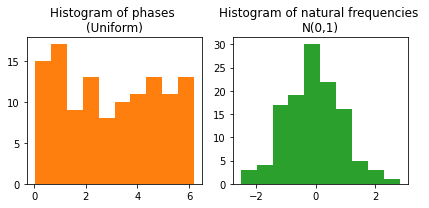

In [17]:
# Initialize parameters
n_nodes = 120
phases = 2 * np.pi * np.random.random(size=n_nodes)
#natfreqs = np.random.normal(loc = 0, scale = 1, size = n_nodes)
# Bring natfreqs from PSH
pre_parameter = loadmat('packages/N120_module4.mat')
natfreqs = pre_parameter['w'].reshape(-1,)


fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].set_title('Histogram of phases \n(Uniform)')
axes[0].hist(phases, color='tab:orange');
axes[1].set_title('Histogram of natural frequencies \nN(0,1)')
axes[1].hist(natfreqs, color='tab:green');
plt.tight_layout()

## Initialize graph topology

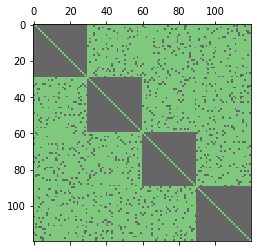

In [18]:
# Make adjacency matrix (A)

#graph_nx = nx.erdos_renyi_graph(n=n_nodes, p=1, seed=42) # p=1 -> all-to-all connectivity
#graph = nx.to_numpy_array(graph_nx)
graph = np.loadtxt('packages/adj_mat_by_PSH.csv', delimiter=',') # Modular topology

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(graph, cmap='Accent')

## Find critical coupling strength

100%|██████████| 51/51 [00:13<00:00,  3.67it/s]


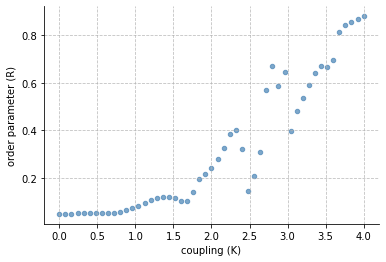

In [19]:
# Find critical point

plot_kuramoto_order(0, 4, 51) # Start, End, Step

## Find node to perturb

M input nodes are : [71 24]


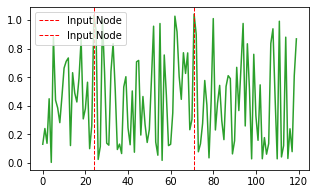

In [20]:
# Let k=2.4
# Now find perturb node

n_inputs = 2 # Rossler x, y, z
p_nodes = np.zeros(n_inputs, dtype=np.intc)

natfreqs_modular = np.mod(abs(natfreqs), np.pi/3)

for i in range(n_inputs):
    max_idx = np.argmax(natfreqs_modular) # Maximum value in natfreqs_modular
    p_nodes[i] = max_idx
    natfreqs_modular[max_idx] = 0
    
# Display index of perturb node
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(np.mod(abs(natfreqs), np.pi/3), color='tab:green')

for i in range(n_inputs):
    #print(i)
    plt.axvline(p_nodes[i], linewidth=1, linestyle='dashed', c='red', label='Input Node')

plt.legend()
print('M input nodes are : {}'.format(p_nodes))

## Visualize Kuramoto model

In [55]:
# Simulate dynamics with critical strength
model = kr.Kuramoto(coupling=2.4, dt=0.01, T=10, n_nodes=n_nodes, natfreqs=natfreqs)
act_mat = model.run(adj_mat=graph, angles_vec=phases)

# Harvest synced state

#initial_synced_phases = act_mat[:,-1]

#Bring settings from PSH
initial_synced_phases = pre_parameter['sync'].reshape(n_nodes,)

In [56]:
len(initial_synced_phases)

120

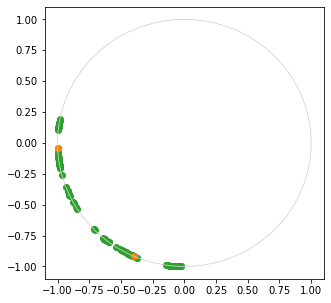

In [57]:
vector2image(initial_synced_phases)

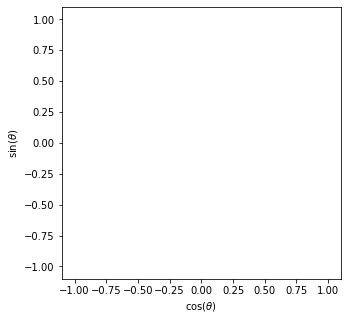

In [ ]:
# Animate model
matrix2video(act_mat=act_mat, start=0, stop=1000, step=10, time_interval=50)

# Load Wind dataset

In [21]:
exp_cos = np.loadtxt('packages/u01_s06_cos_exp_0314.txt')
exp_sin = np.loadtxt('packages/u01_s06_sin_exp_0314.txt')

assert len(exp_cos)==len(exp_sin)
print('Number of points: {}'.format(len(exp_cos)))

Number of points: 8496


Text(0.5, 1.0, 'sin wind')

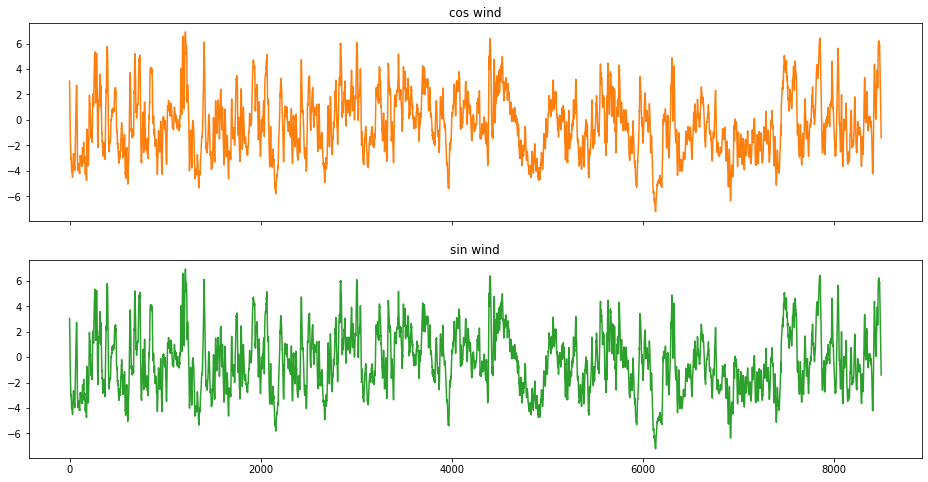

In [22]:
fig, axes = plt.subplots(2, figsize=(16,8), sharex=True)
axes[0].plot(exp_cos, label='cos', color='tab:orange')
axes[0].set_title('cos wind')
axes[1].plot(exp_cos, label='sin', color='tab:green')
axes[1].set_title('sin wind')

In [70]:
len(input_data)/144

59.0

In [23]:
input_data = np.vstack([exp_cos, exp_sin]).T
input_data.shape

(8496, 2)

# Denoising

In [26]:
!pip install pywavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import pywt

In [29]:
def WT(df, col, wavelet='db5', thresh=0.63):
    signal = df[col].values
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

In [33]:
input_df = pd.DataFrame(input_data, columns={'cos', 'sin'})
input_df.head()

,cos,sin
0,3.051000,3.711050
1,2.387503,3.694783
2,2.093943,3.916244
3,1.714626,3.914024
4,1.281374,3.884628


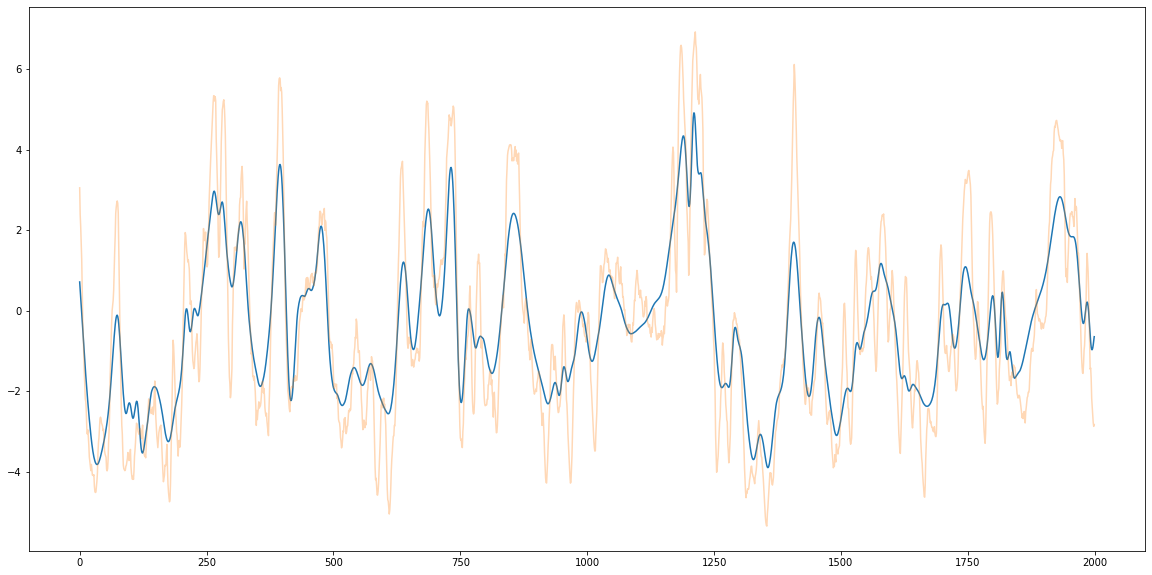

In [74]:
cos_denoised = WT(input_df, 'cos', wavelet='db9', thresh=0.63)
sin_denoised = WT(input_df, 'sin', wavelet='db9', thresh=0.63)

t_lim=2000

fig, ax = plt.subplots(figsize = (20,10))
plt.plot(cos_denoised[:t_lim], label='Denoised')
plt.plot(input_df['cos'][:t_lim], label='Raw', alpha=0.3)

In [59]:
scaler = MinMaxScaler()
input_data_scaled = scaler.fit_transform(np.vstack([cos_denoised, sin_denoised]).T)
input_data_scaled.shape

(8496, 2)

In [60]:
ResSize = 4500
push = 500
trainLen = ResSize-push
trainData = input_data_scaled[push+1:push+trainLen+1,:]

In [61]:
# Now we are ready to perturb data
input_interval = 4
reservoir = []
synced_phases = initial_synced_phases

model = kr.Kuramoto(coupling=2.4, dt=0.01, T=0.01, n_nodes=n_nodes, natfreqs=natfreqs)
synced_phases = getNextPhase(matrix=synced_phases, model=model)

model = kr.Kuramoto(coupling=2.4, dt=0.01, T=input_interval+0.01, n_nodes=n_nodes, natfreqs=natfreqs)

for t in trange(0, ResSize):
    perturbed_phases = getPerturbedPhase(input_data=input_data_scaled, index=p_nodes, phase=synced_phases)
    act_mat = model.run(adj_mat=graph, angles_vec=perturbed_phases)
    
    reservoir.append(getReservoir(matrix=act_mat, time_interval=10))
    synced_phases = getLastPhase(matrix=act_mat)

100%|██████████| 4500/4500 [03:24<00:00, 22.00it/s]


In [62]:
reservoir_T = np.vstack(reservoir)
reservoir_T.shape

(4500, 4680)

In [63]:
trainRes = reservoir_T[push:push+trainLen,:]
print(trainRes.shape, trainData.shape)

(4000, 4680) (4000, 2)


In [64]:
Wout = np.matmul(np.linalg.pinv(trainRes), trainData)

In [65]:
Wout.shape

(4680, 2)

(0.0, 1200.0)

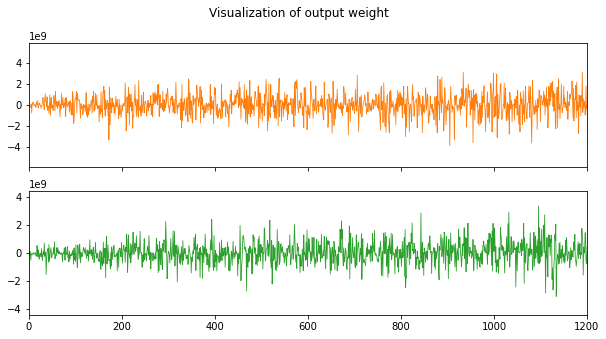

In [66]:
fig, axes = plt.subplots(2, figsize=(10,5), sharex=True)
fig.suptitle('Visualization of output weight')

ylim = 1000000

axes[0].plot(Wout[:,0], linewidth=0.8, color='tab:orange')
axes[0].set_xlim([0,1200])
#axes[0].set_ylim([-ylim,ylim])

axes[1].plot(Wout[:,1], linewidth=0.8, color='tab:green')
axes[1].set_xlim([0,1200])
#axes[1].set_ylim([-ylim,ylim])

In [67]:
testLen = 2000
testData = input_data_scaled[push+trainLen+1:push+trainLen+1+testLen,:]

In [68]:
target = trainData[-1,:].reshape(-1,1)
target

array([[0.77090499],
       [0.49508981]])

In [69]:
pred = []

model = kr.Kuramoto(coupling=2.4, dt=0.01, T=0.01, n_nodes=n_nodes, natfreqs=natfreqs)
synced_phases = getNextPhase(matrix=synced_phases, model=model)

model = kr.Kuramoto(coupling=2.4, dt=0.01, T=input_interval+0.01, n_nodes=n_nodes, natfreqs=natfreqs)


for t in trange(0, testLen):
    for (i,j) in enumerate(p_nodes):
        synced_phases[j] += target[i]
        
    act_mat = model.run(adj_mat=graph, angles_vec = synced_phases)
    act_mat_sampled = act_mat[:, ::10]
    act_mat_diff = np.diff(act_mat_sampled, n=1, axis=1)
    reservoir_t = act_mat_diff.flatten(order='K')
    pred.append(np.matmul(reservoir_t, Wout))

    synced_phases = getLastPhase(matrix=act_mat)
    target = pred[-1]

100%|██████████| 2000/2000 [02:36<00:00, 12.75it/s]


In [71]:
pred = np.vstack(pred)
pred.shape

(2000, 2)

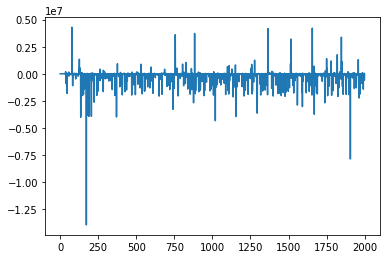

In [72]:
plt.plot(pred[:,1])

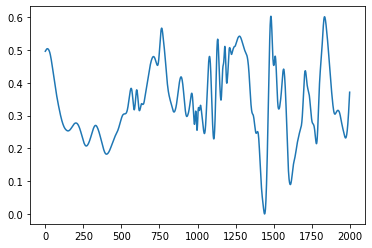

In [73]:
plt.plot(testData[:,1])

# Load Rossler dataset

In [ ]:
data = loadmat('packages/DATA_rossler.mat')

In [ ]:
scaled_x = data['scaled_x']
scaled_y = data['scaled_y']
scaled_z = data['scaled_z']

print(len(scaled_x), len(scaled_y), len(scaled_z))

500001 500001 500001


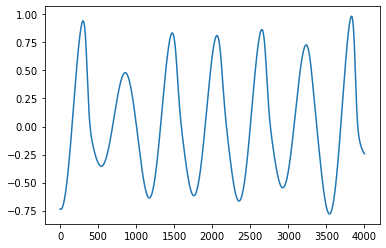

In [ ]:
plt.plot(scaled_x[:4000])

## Add noise to raw data

In [ ]:
noise = 0

input_data = np.concatenate([scaled_x, scaled_y, scaled_z], axis=1)
input_data += noise*np.random.randn(len(input_data), 3)

input_data.shape

(500001, 3)

## Run the reservoir (Train)

In [ ]:
ResSize = 20500
push = 500
trainLen = ResSize-push
trainData = input_data[push+1:push+trainLen+1,:]

In [ ]:
# Now we are ready to perturb data
input_interval = 1
reservoir = []
synced_phases = initial_synced_phases

model = kr.Kuramoto(coupling=2.4, dt=0.01, T=0.01, n_nodes=n_nodes, natfreqs=natfreqs)
synced_phases = getNextPhase(matrix=synced_phases, model=model)

model = kr.Kuramoto(coupling=2.4, dt=0.01, T=input_interval+0.01, n_nodes=n_nodes, natfreqs=natfreqs)

for t in trange(0, ResSize):
    perturbed_phases = getPerturbedPhase(input_data=input_data, index=p_nodes, phase=synced_phases)
    act_mat = model.run(adj_mat=graph, angles_vec=perturbed_phases)
    
    reservoir.append(getReservoir(matrix=act_mat, time_interval=10))
    synced_phases = getLastPhase(matrix=act_mat)

100%|██████████| 20500/20500 [06:39<00:00, 51.30it/s]


In [ ]:
reservoir_T = np.vstack(reservoir)
reservoir_T.shape

(20500, 1200)

## Derive output weight

In [ ]:
trainRes = reservoir_T[push:push+trainLen,:]
print(trainRes.shape, trainData.shape)

(20000, 1200) (20000, 3)


In [ ]:
Wout = np.matmul(np.linalg.pinv(trainRes), trainData)

(-20000.0, 20000.0)

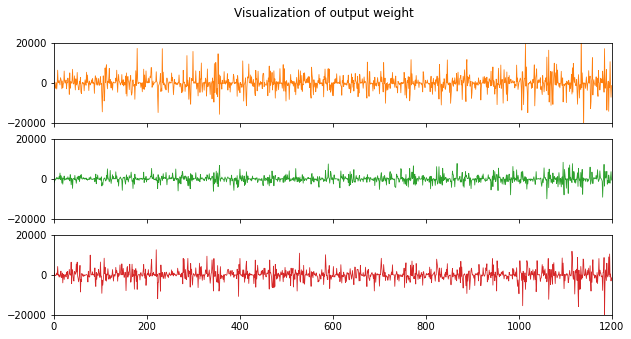

In [ ]:
fig, axes = plt.subplots(3, figsize=(10,5), sharex=True)
fig.suptitle('Visualization of output weight')

ylim = 20000

axes[0].plot(Wout[:,0], linewidth=0.8, color='tab:orange')
axes[0].set_xlim([0,1200])
axes[0].set_ylim([-ylim,ylim])

axes[1].plot(Wout[:,1], linewidth=0.8, color='tab:green')
axes[1].set_xlim([0,1200])
axes[1].set_ylim([-ylim,ylim])

axes[2].plot(Wout[:,2], linewidth=0.8, color='tab:red')
axes[2].set_xlim([0,1200])
axes[2].set_ylim([-ylim,ylim])

## Run the reservoir (Test)

In [ ]:
testLen = 20000
testData = input_data[push+trainLen+1:push+trainLen+1+testLen,:]

In [ ]:
target = trainData[-1,:].reshape(-1,1)
target

array([[-7.60423638e-01],
       [-6.05676692e-02],
       [ 6.07978797e-04]])

In [ ]:
pred = []

model = kr.Kuramoto(coupling=2.4, dt=0.01, T=0.01, n_nodes=n_nodes, natfreqs=natfreqs)
synced_phases = getNextPhase(matrix=synced_phases, model=model)

model = kr.Kuramoto(coupling=2.4, dt=0.01, T=input_interval+0.01, n_nodes=n_nodes, natfreqs=natfreqs)

for t in trange(0, testLen):
    for (i,j) in enumerate(p_nodes):
        synced_phases[j] += target[i]
        
    act_mat = model.run(adj_mat=graph, angles_vec = synced_phases)
    act_mat_sampled = act_mat[:, ::10]
    act_mat_diff = np.diff(act_mat_sampled, n=1, axis=1)
    reservoir_t = act_mat_diff.flatten(order='K')
    pred.append(np.matmul(reservoir_t, Wout))

    synced_phases = getLastPhase(matrix=act_mat)
    target = pred[-1]

100%|██████████| 20000/20000 [06:20<00:00, 52.62it/s]


In [ ]:
pred = np.vstack(pred)
pred.shape

(20000, 3)

## Visualize result

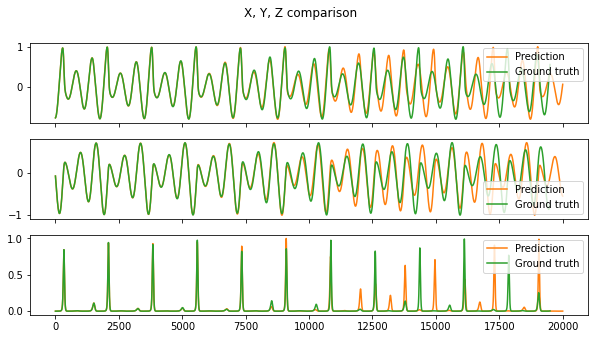

In [ ]:
fig, axes = plt.subplots(3, figsize=(10,5), sharex=True)

fig.suptitle('X, Y, Z comparison')
axes[0].plot(pred[:,0], color='tab:orange', label='Prediction')
axes[0].plot(testData[:,0][:-push], color='tab:green', label='Ground truth')
axes[0].legend()

axes[1].plot(pred[:,1], color='tab:orange', label='Prediction')
axes[1].plot(testData[:,1][:-push], color='tab:green', label='Ground truth')
axes[1].legend()

axes[2].plot(pred[:,2], color='tab:orange', label='Prediction')
axes[2].plot(testData[:,2][:-push], color='tab:green', label='Ground truth')
axes[2].legend()

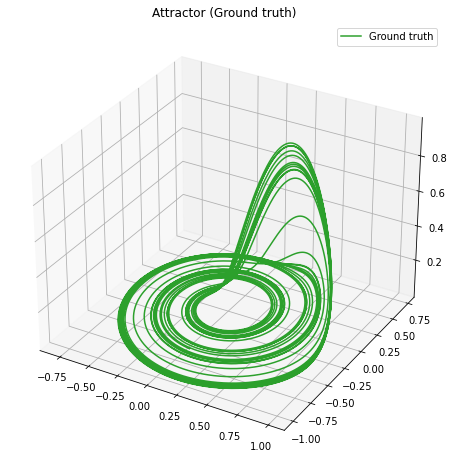

In [ ]:
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
ax.set_title('Attractor (Ground truth)')
ax.plot(testData[:,0], testData[:,1], testData[:,2], label='Ground truth', color='tab:green')
ax.legend()

plt.show()

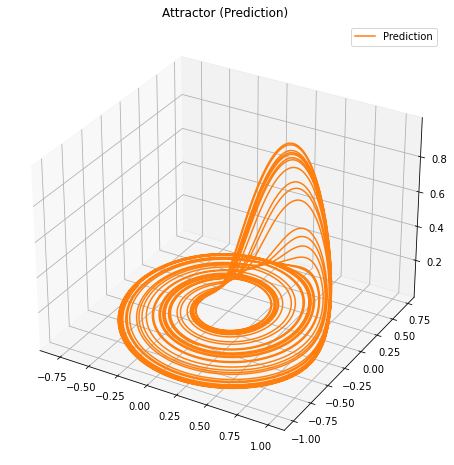

In [ ]:
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
ax.set_title('Attractor (Prediction)')
ax.plot(pred[:,0], pred[:,1], pred[:,2], label='Prediction', color='tab:orange')
ax.legend()

plt.show()